# Model Training: 
### Part 1 >>> Predictions at the beginning of the race, no data given during the race is used.

Here we see how close we can predict a race outcome with just data from the Ergast API



In [435]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExajJ0cHhpdnV3NmhpcThscjJ6c3lmd2xvdTVibHluY3hxMDhzZ3lxdiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/SXxMF5CMWWKZUkBBgJ/giphy.gif")

### 1) Importing Packages and Data

In [436]:
import pandas as pd
import numpy as np
import F1_Preprocessing #Internal package to preprocess data
import F1_Modelling_Extra_Functions # Internal package here used to evaluate models
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV #cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier


np.random.seed(1994)
pd.set_option('display.max_columns', None)
plt.figure(dpi=150)

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

In [437]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "1_API_Requests_Ergast.py"

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

ResultsDF=pd.read_csv(path+"ResultsDF.csv")
ResultsDF=ResultsDF[ResultsDF["season"]>=2017]

### 2) Data Preprocessing

In [438]:
# Apply the data preprocessing for each df using a function stored in the repo from F1_Preprocessing.py 
# This is done this way so the preprocessing is consistent throughout all notebooks.
# With this code we:
#   - create new features
#   - format dates and floats
#   - encode features
#   - null handling

ResultsDF=F1_Preprocessing.preprocess_F1results(ResultsDF,OneHotEncoder=True,HandleNulls=True)


c:\Users\gabri\Dropbox\Gaby\Proyectos\My_Portafolio\F1\F1_PredictingPodiumAlgorithm\F1_Preprocessing.py:87: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [439]:
# Group features for further analysis:
selected_features_circuit_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("circuit.circuitid_")].columns.to_list()
selected_features_constructor_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("constructor.constructorid_")].columns.to_list()
selected_features_driver_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("driverid_")].columns.to_list()
selected_features_status_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("final_status_grouped_")].columns.to_list()
selected_features_general=[col for col in ResultsDF.columns if col not in selected_features_circuit_focused+
                           selected_features_constructor_focused+selected_features_driver_focused+selected_features_status_focused]

# Not all the features in these dataframe are available before hand. 
# Below we remove features we don't know before the race starts (apart from dependent variables).
# Here we add features to each observation to have a view of what happened the races before to the same driver
features_to_add_from_the_past=['driverid',"season-round",'final_position','final_grid','fastestlap.rank','race_time_millis_to_max_ratio'] #'final_points'

features_to_add_from_the_past+=selected_features_status_focused

print(len(features_to_add_from_the_past))

# Add certain features to see how the driver performed in previous races
ResultsDF2=F1_Preprocessing.get_past_rows(DF=ResultsDF,
                                          N=5,
                                          iterator_feature='driverid',
                                          grouper_feature='season-round',
                                          features_added=features_to_add_from_the_past)

ResultsDF2.drop(columns=ResultsDF2.loc[:, ResultsDF2.columns.str.startswith("driverid-")].columns.to_list(),inplace=True)
ResultsDF2[list(set(ResultsDF2.columns)-set(ResultsDF.columns))]=ResultsDF2[list(set(ResultsDF2.columns)-set(ResultsDF.columns))].astype(float)

13


c:\Users\gabri\Dropbox\Gaby\Proyectos\My_Portafolio\F1\F1_PredictingPodiumAlgorithm\F1_Preprocessing.py:226: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  OBS_DF_N = pd.concat([empty_rows, OBS_DF], ignore_index=True)[features_added]
c:\Users\gabri\Dropbox\Gaby\Proyectos\My_Portafolio\F1\F1_PredictingPodiumAlgorithm\F1_Preprocessing.py:226: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  OBS_DF_N = pd.concat([empty_rows, OBS_DF], ignore_index=True)[features_added]
c:\Users\gabri\Dropbox\Gaby\Proyec

In [440]:
#Features to remove (not available during the race, text, already encoded features)

selected_features_seasonround_focused=ResultsDF2.loc[:, ResultsDF2.columns.str.startswith("season-round-")].columns.to_list()

features_to_remove=['driver_number', 'final_positionText', 'final_points','final_laps','driver.givenname', 'driver.familyname',
       'driver.dateofbirth', 'driver.nationality', 'constructor.url','constructor.name', 'constructor.nationality',
       'fastestlap.rank', 'fastestlap.lap', 'fastestlap.time.time','fastestlap.averagespeed.speed','racename',
       'circuit.circuitname', 'circuit.location.country', 'date','fastestlap.time.in_milliseconds',
       'season-round-driverid','race_time_millis_max_round_season','race_time_millis_min_round_season',
       'race_time_millis_avg_round_season', 'race_time_millis_to_max_ratio','race_time_millis_to_min_ratio', 'race_time_millis_to_avg_ratio',
       'final_status_grouped','circuit.circuitid','constructor.constructorid','driverid']
features_to_remove=features_to_remove+selected_features_status_focused+selected_features_seasonround_focused

ResultsDF2=ResultsDF2.drop(columns=features_to_remove)

#Create extra feature
ResultsDF2["final_position_is_podium"]=np.where(ResultsDF2["final_position"].isin([1,2,3]),1,0)


### 3) Check Linear Correlation

This is done to understand if there is any feature that is strong enough in terms of correlation with the dependent features : final position and race time

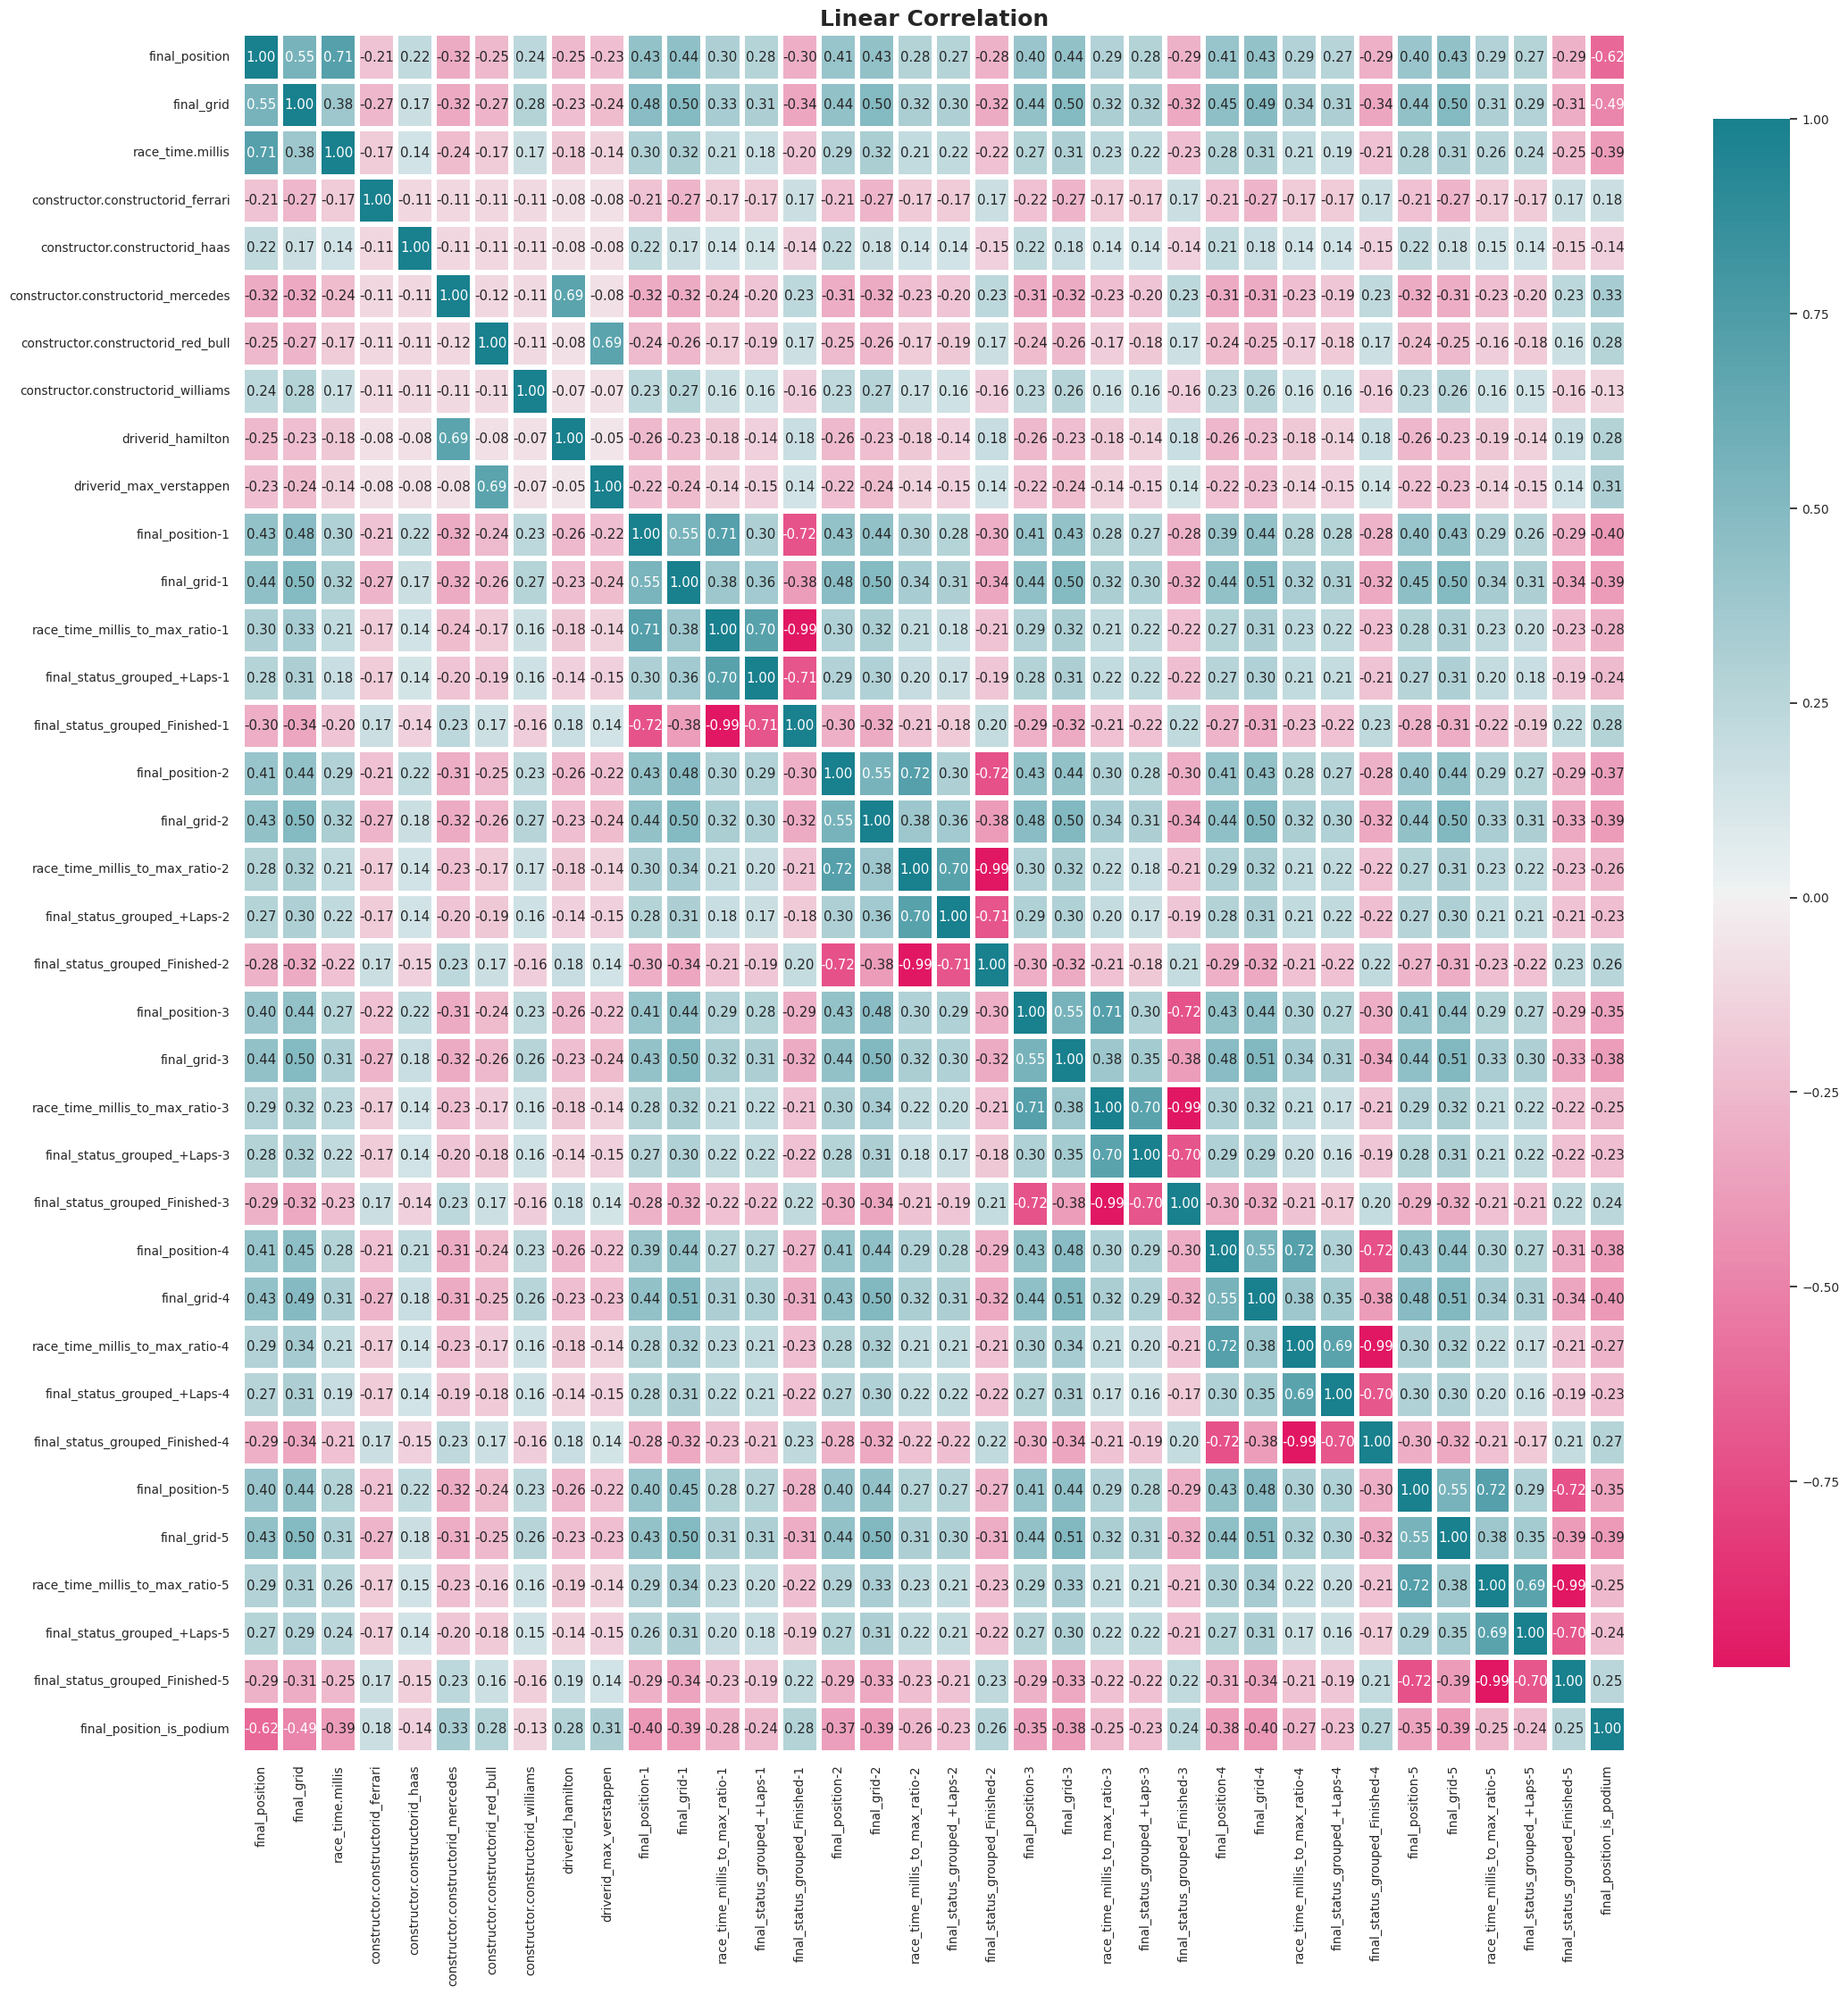

In [441]:

#Create and filter correlation df by absolute correlation value
corr_chosen=0.20
DF=ResultsDF2.select_dtypes(exclude=['object'])
df_corr=DF[DF.columns].corr()
# high_corr_var=df_corr[(df_corr["race_time.millis"].abs() > corr_chosen)].index
high_corr_var=df_corr[(df_corr["final_position"].abs() > corr_chosen)].index
filtered_corr=df_corr.loc[high_corr_var,high_corr_var]

#Plot df
sns.set_theme(style="whitegrid", font_scale=0.9,font="DejaVu Sans")
fig, axs = plt.subplots(figsize=(25,25))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(filtered_corr, annot=True, fmt=".2f", linewidths=3, cmap=cmap,cbar_kws={"shrink": .9},ax=axs)
axs.set_title('Linear Correlation',fontsize=18,fontweight='bold')
plt.show()


### 4) Models

#### A. Random Forest Classifier (Predict All Final Positions)

In [442]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
EXCLUDED_COLS=['final_position_is_podium','race_time.millis','season','round']
TEST_SEGMENTS=np.sort(ResultsDF2["season-round"].unique())[-15:]
TEST_DF=ResultsDF2[ResultsDF2["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)
TRAINING_VALIDATION_DF=ResultsDF2[~ResultsDF2["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='final_position'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET]

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET]

Test DF: 296
Train Validation DF: 2763


Best Estimator:  RandomForestClassifier(max_depth=5, min_samples_leaf=30)
Best Score:  0.15236522787430878


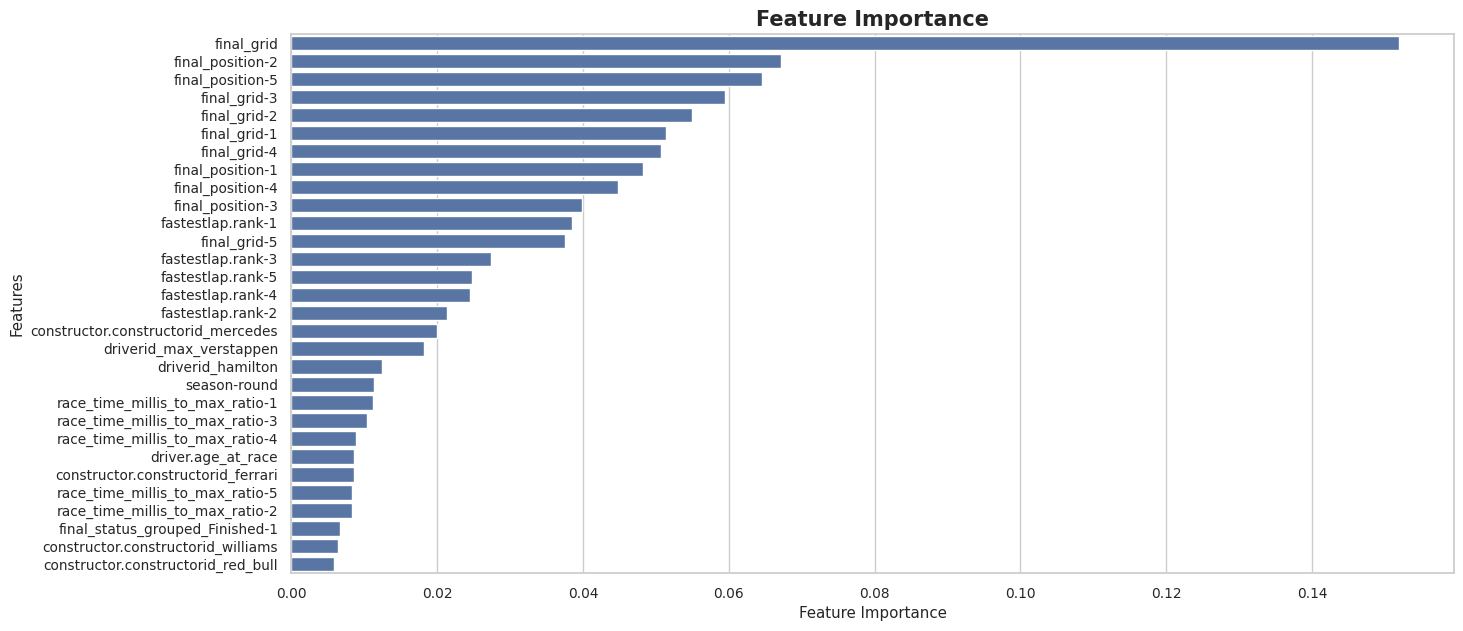

In [443]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = RandomForestClassifier()

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'max_depth': [5,10,15,20],
    # 'min_samples_split': [5,10,15],
    'min_samples_leaf': [5,10,20,30,40]
    }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='accuracy', return_train_score=True)
grid_search.fit(X, y)

cv_results,best_model=F1_Modelling_Extra_Functions.grid_search_show_results(gs=grid_search,
                                                                            X_df=X,
                                                                            feature_importance_num_features=30,
                                                                            figuresize=(15,7))

Accuracy:  0.14189189189189189
F1 Score:  0.1075743379065961


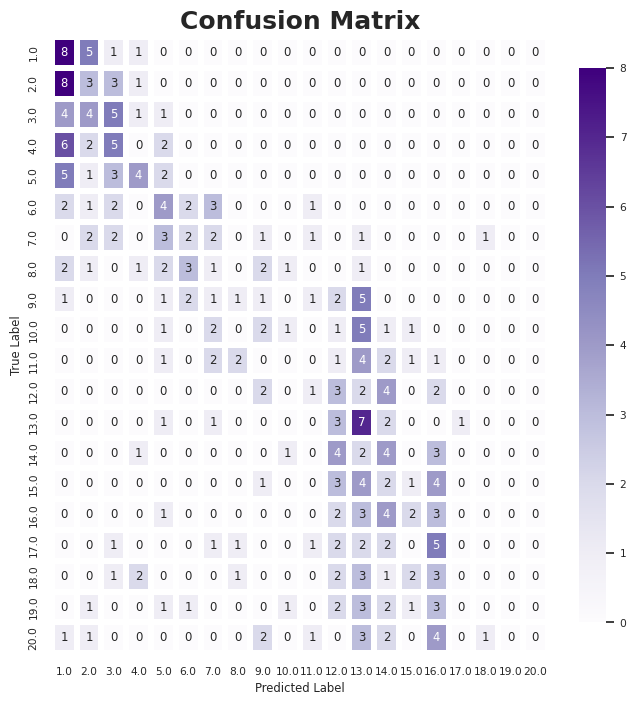

              precision    recall  f1-score   support

         1.0       0.22      0.53      0.31        15
         2.0       0.14      0.20      0.17        15
         3.0       0.22      0.33      0.26        15
         4.0       0.00      0.00      0.00        15
         5.0       0.10      0.13      0.11        15
         6.0       0.20      0.13      0.16        15
         7.0       0.15      0.13      0.14        15
         8.0       0.00      0.00      0.00        14
         9.0       0.09      0.07      0.08        15
        10.0       0.25      0.07      0.11        14
        11.0       0.00      0.00      0.00        14
        12.0       0.12      0.21      0.15        14
        13.0       0.16      0.47      0.23        15
        14.0       0.15      0.27      0.20        15
        15.0       0.12      0.07      0.09        15
        16.0       0.11      0.20      0.14        15
        17.0       0.00      0.00      0.00        15
        18.0       0.00    

c:\Users\gabri\Dropbox\Gaby\Proyectos\My_Portafolio\F1\F1_PredictingPodiumAlgorithm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gabri\Dropbox\Gaby\Proyectos\My_Portafolio\F1\F1_PredictingPodiumAlgorithm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gabri\Dropbox\Gaby\Proyectos\My_Portafolio\F1\F1_PredictingPodiumAlgorithm\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w

In [444]:
# Try model in test set
y_pred = best_model.predict(X_test)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1 Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test,y_pred,figuresize=(8,8)) #confusion matrix and classification report

After tuning the hyperparameters and adjusting the amount of historical data for each driver, we found that using a Random Forest classifier with this dataset doesn’t result in strong predictions for all final race positions (based solely on previous information). However, the model shows better performance when predicting podium finishes. Below we try to predict the podium positions with the same method.

#### B. Random Forest Classifier (Predict Podium Positions)

In [445]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
EXCLUDED_COLS=['final_position','race_time.millis','season','round']
TEST_SEGMENTS=np.sort(ResultsDF2["season-round"].unique())[-15:]
TEST_DF=ResultsDF2[ResultsDF2["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)
TRAINING_VALIDATION_DF=ResultsDF2[~ResultsDF2["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='final_position_is_podium'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET]

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET]

Test DF: 296
Train Validation DF: 2763


Best Estimator:  RandomForestClassifier(max_depth=15, min_samples_leaf=5)
Best Score:  0.8896074114841314


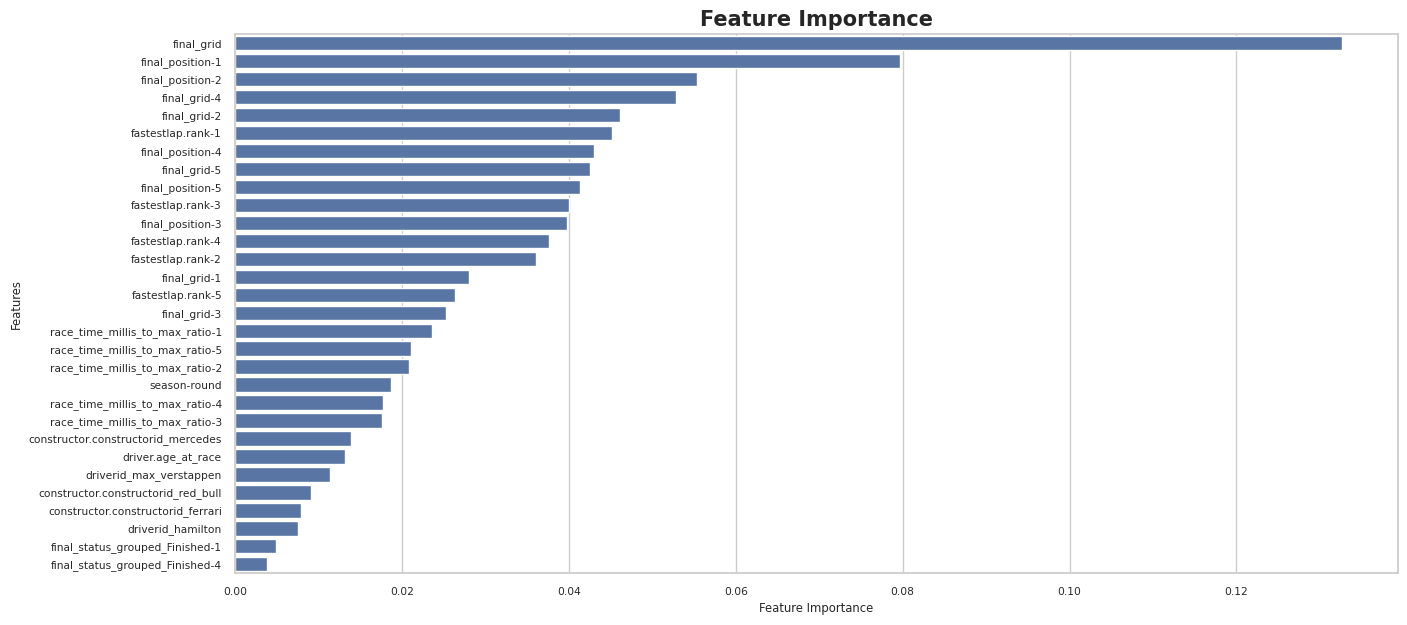

In [446]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = RandomForestClassifier()

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'max_depth': [5,10,15,20],
    # 'min_samples_split': [],
    'min_samples_leaf': [5,10,20,30,40]
    }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='accuracy', return_train_score=True)
grid_search.fit(X, y)

cv_results,best_model=F1_Modelling_Extra_Functions.grid_search_show_results(gs=grid_search,
                                                                            X_df=X,
                                                                            feature_importance_num_features=30,
                                                                            figuresize=(15,7))

Accuracy:  0.9054054054054054
F1 Score:  0.7837837837837838


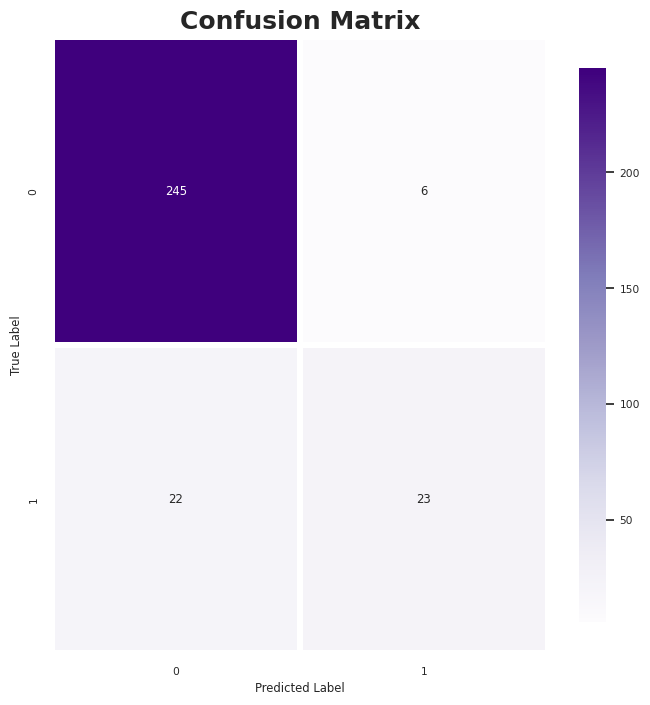

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       251
           1       0.79      0.51      0.62        45

    accuracy                           0.91       296
   macro avg       0.86      0.74      0.78       296
weighted avg       0.90      0.91      0.90       296



In [447]:
# Try model in test set
y_pred = best_model.predict(X_test)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1 Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test,y_pred,figuresize=(8,8)) #confusion matrix and classification report

The results appear to be better; however, the metrics are misleading as the dataset is highly imbalanced when predicting podium positions. From 45 podium observations, only 23 were predicted correctly. There is overfitting in the models. Below I apply PCA to try to reduce the number of features for the model (there are many that are similar to each other). This will reduce the dimensionality and the noise.

#### C. Random Forest Classifier (Predict All Final Positions) + PCA 

In [456]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
EXCLUDED_COLS=['final_position','race_time.millis']
TEST_SEGMENTS=np.sort(ResultsDF2["season-round"].unique())[-15:]
TEST_DF=ResultsDF2[ResultsDF2["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)
TRAINING_VALIDATION_DF=ResultsDF2[~ResultsDF2["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='final_position_is_podium'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET]

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET]


scaler = preprocessing.StandardScaler()
X_SCALED = scaler.fit_transform(X)
X_test_SCALED = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=5)  
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)

np.set_printoptions(suppress=True)
print('Explained variability per principal component (top 10): {}'.format(pca.explained_variance_ratio_[:10]))
print('All principal components hold: {} of the information'.format(sum(pca.explained_variance_ratio_)))

num_components = X_pca.shape[1]
column_names = [f'PC{i+1}' for i in range(num_components)] 
X_pca_df = pd.DataFrame(X_pca, columns=column_names)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=column_names)


Test DF: 296
Train Validation DF: 2763
Explained variability per principal component (top 10): [0.21486663 0.21079579 0.20533879 0.19180826 0.17719053]
All principal components hold: 0.9999999999998029 of the information


In [449]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = RandomForestClassifier()

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'max_depth': [5,10,15],
    # 'min_samples_split': [],
    'min_samples_leaf': [10,20,40]
    }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='accuracy', return_train_score=True)
grid_search.fit(X_pca_df, y)

cv_results,best_model=F1_Modelling_Extra_Functions.grid_search_show_results(gs=grid_search,
                                                                            X_df=X_pca_df,
                                                                            feature_importance_num_features=0,
                                                                            figuresize=(15,5))

Best Estimator:  RandomForestClassifier(max_depth=5, min_samples_leaf=20)
Best Score:  0.8689807898943837
-------------------------------------------------------------------------------------


Accuracy:  0.8141891891891891
F1 Score:  0.5598929469330377


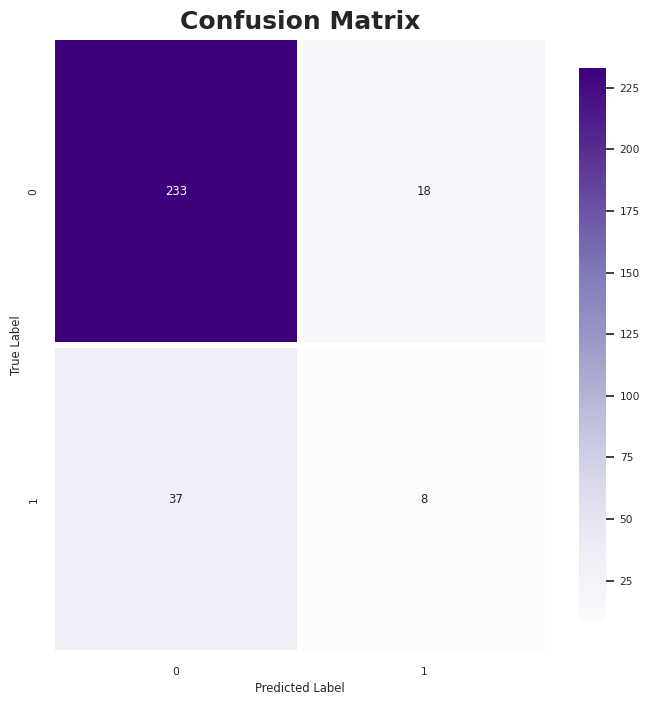

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       251
           1       0.31      0.18      0.23        45

    accuracy                           0.81       296
   macro avg       0.59      0.55      0.56       296
weighted avg       0.78      0.81      0.79       296



In [450]:
# Try model in test set
y_pred = best_model.predict(X_test_pca_df)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1 Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test,y_pred,figuresize=(8,8)) #confusion matrix and classification report

We are trying another multiclass classifier, XGBoost, instead of RFC. This as it includes different methods to handle overfitting in comparison to the random forest classifier.

#### D. XGBoost (Predict All Final Positions)

In [451]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
EXCLUDED_COLS=['final_position_is_podium','race_time.millis']
TEST_SEGMENTS=np.sort(ResultsDF2["season-round"].unique())[-15:]
TEST_DF=ResultsDF2[ResultsDF2["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)
TRAINING_VALIDATION_DF=ResultsDF2[~ResultsDF2["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='final_position'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET].astype(int)-1

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET].astype(int)-1

Test DF: 296
Train Validation DF: 2763


Best Estimator:  XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
Best Score:  0.13717207851770316


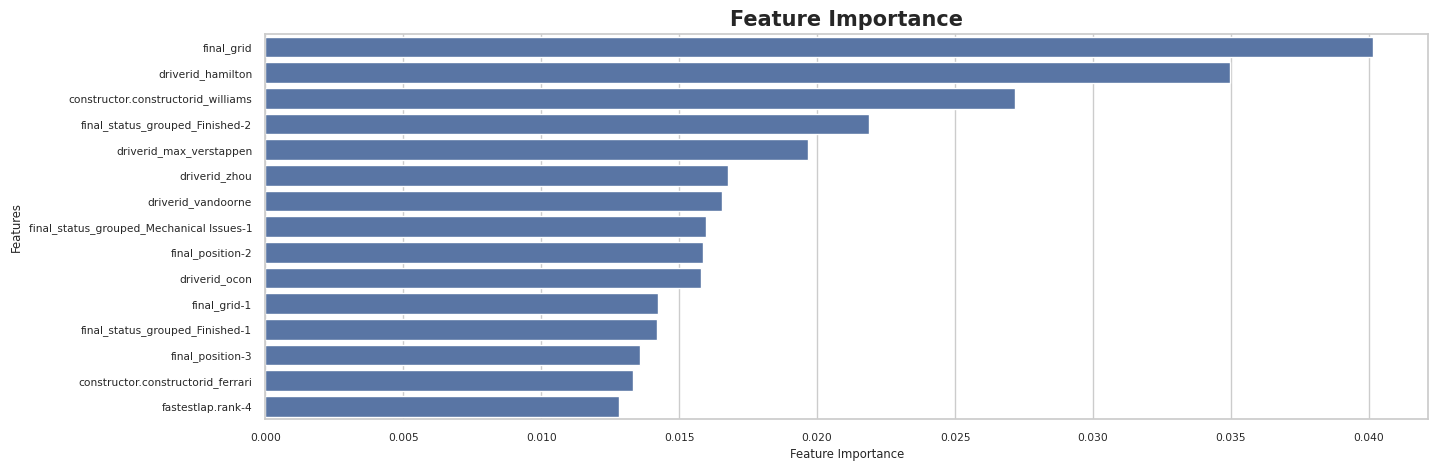

In [452]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = XGBClassifier()

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'booster':['gbtree','dart'],
    'max_depth': [5,10],
    'eta':[0.01],
    # 'alpha':[0.1],
    # 'lambda':[1],
    }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='accuracy', return_train_score=True)
grid_search.fit(X, y)

cv_results,best_model=F1_Modelling_Extra_Functions.grid_search_show_results(gs=grid_search,
                                                                            X_df=X,
                                                                            feature_importance_num_features=15,
                                                                            figuresize=(15,5))



Accuracy:  0.16891891891891891
F1 Score:  0.1472207839558191


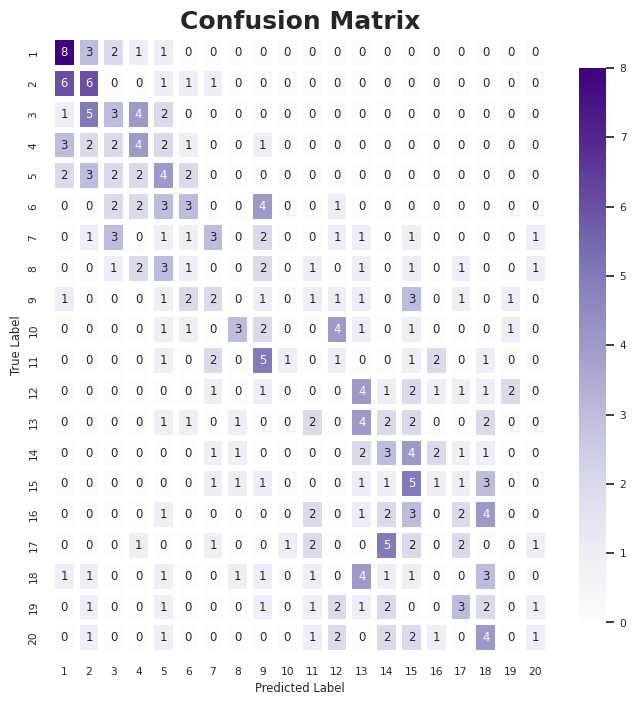

              precision    recall  f1-score   support

           1       0.36      0.53      0.43        15
           2       0.26      0.40      0.32        15
           3       0.20      0.20      0.20        15
           4       0.25      0.27      0.26        15
           5       0.16      0.27      0.20        15
           6       0.23      0.20      0.21        15
           7       0.25      0.20      0.22        15
           8       0.00      0.00      0.00        14
           9       0.05      0.07      0.06        15
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00        14
          13       0.19      0.27      0.22        15
          14       0.16      0.20      0.18        15
          15       0.18      0.33      0.23        15
          16       0.00      0.00      0.00        15
          17       0.17      0.13      0.15        15
          18       0.14    

In [453]:
# Try model in test set
y_pred = best_model.predict(X_test)

# Metrics
test_accuracy = accuracy_score(y_test+1, y_pred+1)
test_f1 = f1_score(y_test+1, y_pred+1, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1 Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test+1,y_pred+1,figuresize=(8,8)) #confusion matrix and classification report